In [1]:
!pip install Pillow
!pip install tensorflow

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import xml.dom.minidom
import os

from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np

2023-03-10 15:45:39.343674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [127]:
path_suff = "maksssksksss"
n = 853

classes = ['with_mask', 'mask_weared_incorrect', 'without_mask']

def return_code(label):
    return classes.index(label)

imgs = []
labels = []
for i in range(n):
    img = Image.open('./images/{suff}{num}.png'.format(suff=path_suff, num=str(i)))
    
    doc = xml.dom.minidom.parse('./annotations/{suff}{num}.xml'.format(suff=path_suff, num=str(i)))
    names = doc.getElementsByTagName("name")
    xmins = doc.getElementsByTagName("xmin")
    ymins = doc.getElementsByTagName("ymin")
    xmaxs = doc.getElementsByTagName("xmax")
    ymaxs = doc.getElementsByTagName("ymax")
    
    for j in range(len(names)):
        labels.append([return_code(names[j].firstChild.data)])
        temp = img.crop((float(xmins[j].firstChild.data), float(ymins[j].firstChild.data),
                         float(xmaxs[j].firstChild.data), float(ymaxs[j].firstChild.data))).convert('RGB')
        
        temp = tf.image.convert_image_dtype(temp, tf.float32)
        
        imgs.append(np.asarray(tf.image.resize(temp, (32, 32))))

print("Number of Images: " + str(len(imgs)))

Number of Images: 4072


In [128]:
training_split = 0.75
print("Number of Training Images: " + str(int(len(imgs)*(training_split))))
print("Number of Test Images: " + str(int(len(imgs)*(1-training_split))))

Number of Training Images: 3054
Number of Test Images: 1018


In [140]:
train_images, test_images, train_labels, test_labels = train_test_split(imgs, labels, test_size = 0.25)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

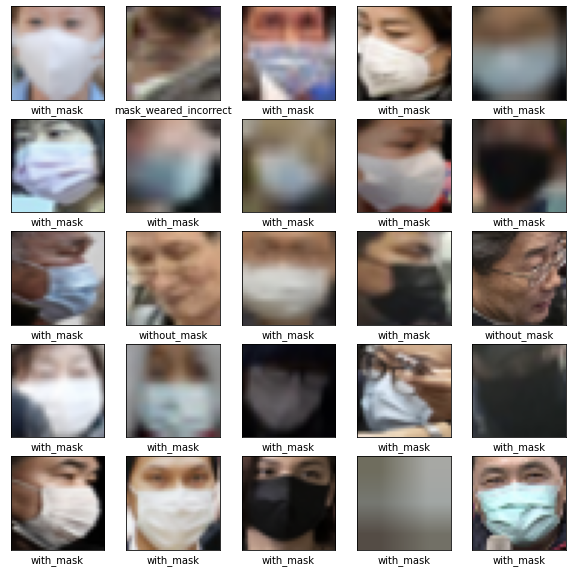

In [141]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(classes[train_labels[i][0]])
plt.show()

In [142]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [143]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-trai

In [144]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [145]:
print(np.array(train_images, dtype=object).shape)

(3054, 32, 32, 3)


In [146]:
print(train_labels.shape)

(3054, 1)


In [148]:
print(np.array(test_images, dtype=object).shape)

(1018, 32, 32, 3)


In [147]:
print(test_labels.shape)

(1018, 1)


In [150]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(np.array(train_images), train_labels, epochs=10,
                    validation_data=(np.array(test_images), test_labels))

Epoch 1/10
96/96 [==============================] - 3s 20ms/step - loss: 0.2441 - accuracy: 0.9234 - val_loss: 0.2643 - val_accuracy: 0.9283
Epoch 2/10
96/96 [==============================] - 2s 19ms/step - loss: 0.2063 - accuracy: 0.9384 - val_loss: 0.2168 - val_accuracy: 0.9391
Epoch 3/10
96/96 [==============================] - 2s 20ms/step - loss: 0.1885 - accuracy: 0.9384 - val_loss: 0.2315 - val_accuracy: 0.9293
Epoch 4/10
96/96 [==============================] - 2s 20ms/step - loss: 0.1878 - accuracy: 0.9388 - val_loss: 0.1977 - val_accuracy: 0.9361
Epoch 5/10
96/96 [==============================] - 3s 31ms/step - loss: 0.1673 - accuracy: 0.9394 - val_loss: 0.1939 - val_accuracy: 0.9371
Epoch 6/10
96/96 [==============================] - 3s 33ms/step - loss: 0.1547 - accuracy: 0.9489 - val_loss: 0.1948 - val_accuracy: 0.9411
Epoch 7/10
96/96 [==============================] - 3s 34ms/step - loss: 0.1432 - accuracy: 0.9528 - val_loss: 0.1940 - val_accuracy: 0.9352
Epoch 8/10
96

32/32 - 0s - loss: 0.1700 - accuracy: 0.9430 - 263ms/epoch - 8ms/step


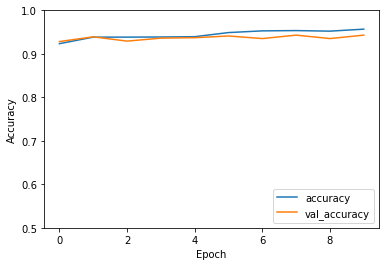

In [152]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(np.array(test_images),  test_labels, verbose=2)

TypeError: only integer scalar arrays can be converted to a scalar index

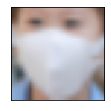

In [158]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(classes[model.predict(np.concatenate(np.array([None]), np.array(train_images[i])))])
plt.show()